In [1]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

model_name = "cardiffnlp/twitter-roberta-base-sentiment-latest"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
model.eval()


config.json:   0%|          | 0.00/929 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


pytorch_model.bin:   0%|          | 0.00/501M [00:00<?, ?B/s]

Error while downloading from https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment-latest/resolve/main/pytorch_model.bin: HTTPSConnectionPool(host='cas-bridge.xethub.hf.co', port=443): Read timed out.
Trying to resume download...


pytorch_model.bin:  29%|##9       | 147M/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/501M [00:00<?, ?B/s]

In [2]:
model.config.id2label


{0: 'negative', 1: 'neutral', 2: 'positive'}

In [3]:
import torch.nn.functional as F

def predict_sentiment(text):
    # Tokenize input
    inputs = tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        padding=True,
        max_length=128
    )

    # Model inference
    with torch.no_grad():
        outputs = model(**inputs)

    # Convert logits to probabilities
    probs = F.softmax(outputs.logits, dim=1)

    # Get predicted label
    predicted_class_id = probs.argmax(dim=1).item()
    sentiment = model.config.id2label[predicted_class_id]
    confidence = probs.max().item()

    return sentiment, confidence


In [7]:
text = "The service was  not bad , need many improvements"
sentiment, confidence = predict_sentiment(text)

print(f"Sentiment: {sentiment}")
print(f"Confidence: {confidence:.2f}")


Sentiment: positive
Confidence: 0.70


In [29]:
import pandas as pd

df = pd.read_csv('../data/stakeholder_comments_500.csv')


In [30]:
df.columns


Index(['comment_id', 'comment_text', 'expected_sentiment'], dtype='object')

In [31]:
df[['predicted_sentiment', 'confidence']] = df['comment_text'].apply(
    lambda x: pd.Series(predict_sentiment(str(x)))
)

df.head()


,comment_id,comment_text,expected_sentiment,predicted_sentiment,confidence
0,1,The proposed amendment will significantly impr...,Positive,positive,0.889820
1,2,This draft law simplifies reporting requiremen...,Positive,positive,0.710450
2,3,The amendment appears beneficial for startups ...,Positive,positive,0.896677
3,4,I strongly support this amendment as it promot...,Positive,positive,0.943474
4,5,This change will encourage better corporate go...,Positive,positive,0.836372


In [32]:
df['expected_sentiment'] = df['expected_sentiment'].str.lower().str.strip()


In [ ]:
df.to_csv('../data/sentiment_results.csv', index=False)


In [34]:
print("Expected labels:", df['expected_sentiment'].unique())
print("Predicted labels:", df['predicted_sentiment'].unique())


Expected labels: ['positive' 'neutral' 'negative']
Predicted labels: ['positive' 'neutral' 'negative']


In [35]:
from sklearn.metrics import classification_report

print(
    classification_report(
        df['expected_sentiment'],
        df['predicted_sentiment'],
        labels=['negative', 'neutral', 'positive']
    )
)


              precision    recall  f1-score   support

    negative       0.90      0.90      0.90       150
     neutral       0.89      0.80      0.84       150
    positive       0.93      1.00      0.96       200

    accuracy                           0.91       500
   macro avg       0.91      0.90      0.90       500
weighted avg       0.91      0.91      0.91       500



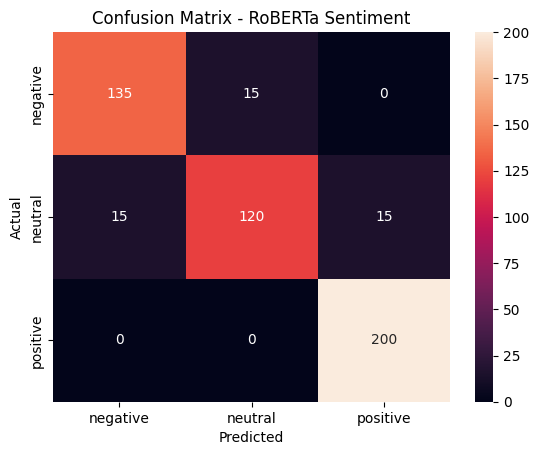

In [36]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(
    df['expected_sentiment'],
    df['predicted_sentiment'],
    labels=['negative', 'neutral', 'positive']
)

sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=['negative', 'neutral', 'positive'],
            yticklabels=['negative', 'neutral', 'positive'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - RoBERTa Sentiment")
plt.show()


In [37]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(
    df['expected_sentiment'],
    df['predicted_sentiment']
)

print(f"Accuracy: {accuracy:.4f}")


Accuracy: 0.9100
